<a href="https://colab.research.google.com/github/felipeodorcyk/Data_Science_Portfolio/blob/main/AlzheimerDiseaseProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The history of Alzheimer's Disease research told by Natural Language Processing

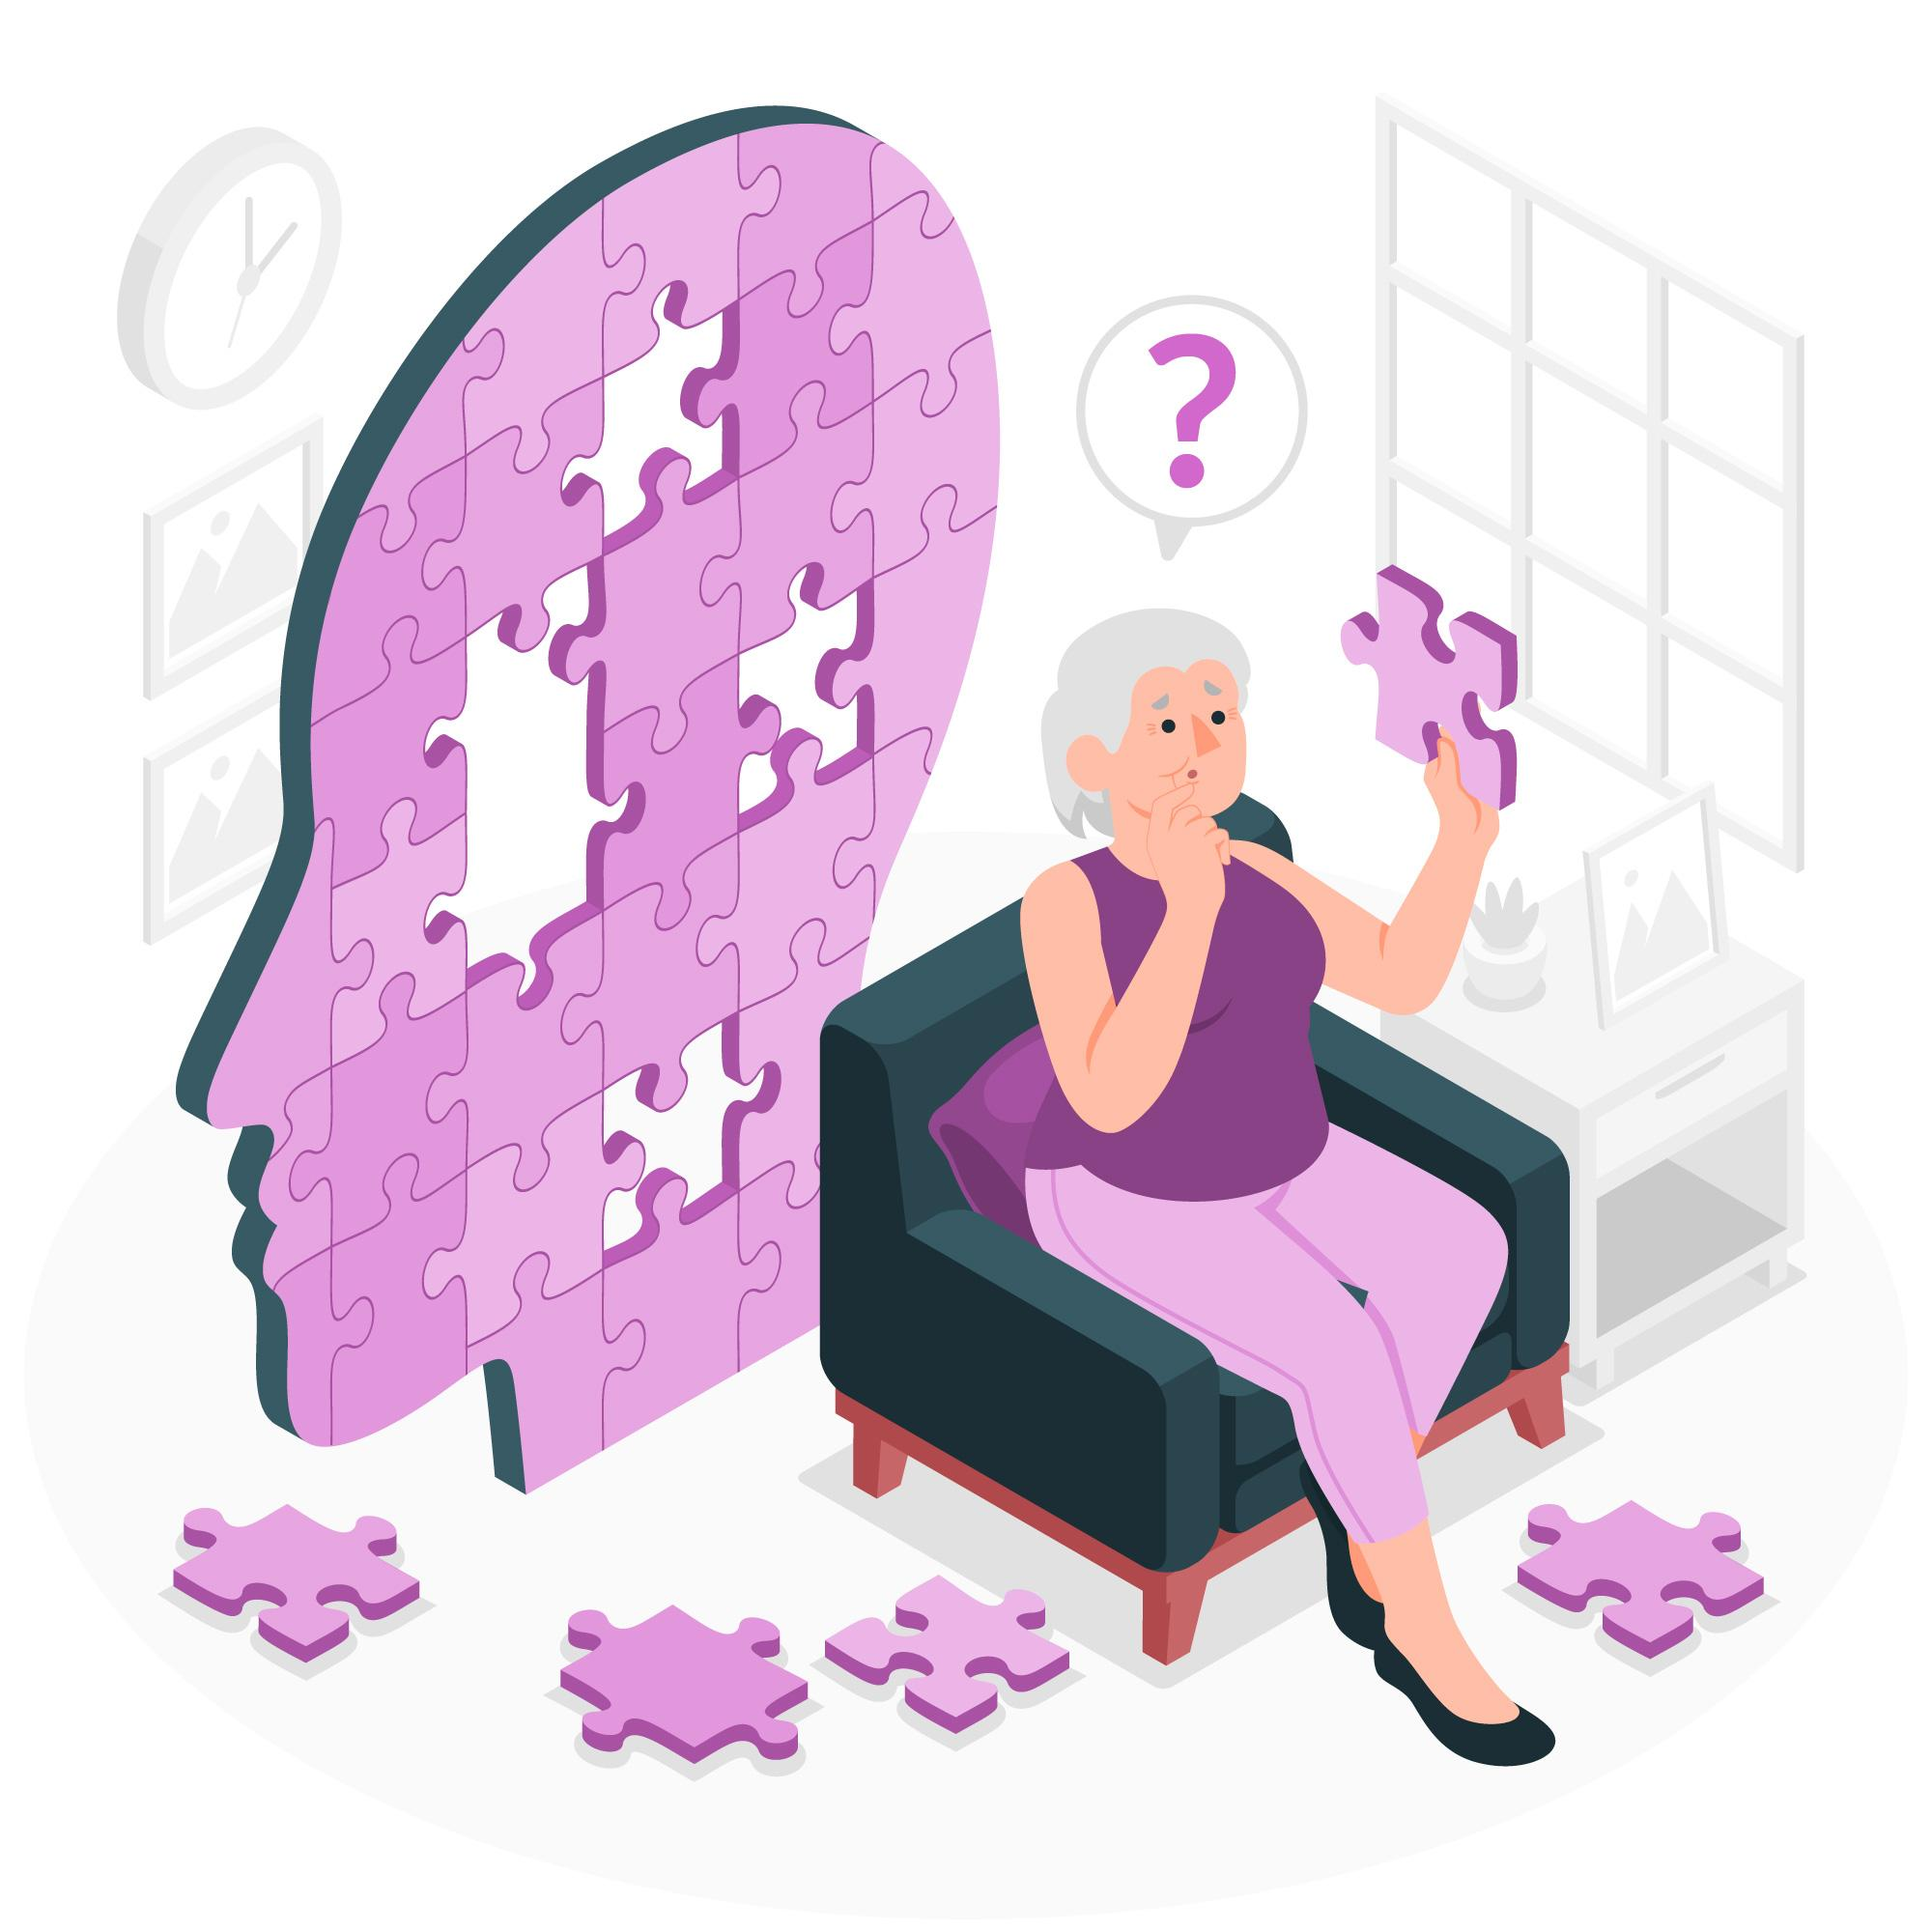

<a href='https://br.freepik.com/fotos-vetores-gratis/ponto-de-interrogacao'>Created by stories - Available at br.freepik.com</a>

Alzheimer's Disease causes memory loss and impairs cognitive abilities to a point that affects daily life. This disease affects the life of millions of people worldwide, most of them over 65 years of age, being among the main causes of mortality in older people. This disease was first described by Dr. Alois Alzheimer in 1906. For more than one century, undestanding the mechanisms underlying Alzheimer's Disease progression and finding new therapeutic strategies for it have been a major challenge to scientists around the world.

Here Natural Language Processing is used to look at the history of Alzheimer's research from a different pespective.




##1.Data mining and cleaning

With this in mind, abstracts from peer reviewed studies published in scientific journals were obtained from PubMed using the APIs E-search and E-fetch.

###Code:

In [ ]:
#Instalations and updates required to run in google colab notebook
!pip install biopython
!pip install plotly --upgrade
!pip install bar_chart_race
!pip install apyori

In [ ]:
#Imports
from Bio import Entrez
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(10)
import plotly.express as px
import string
import nltk
nltk.download('stopwords')
import wordcloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Using e-search API to find PubMed search results
def search(query):
    Entrez.email = 'felipe.odorcyk@gmail.com'
    handle = Entrez.esearch(db='pubmed',
                            sort='relevance',
                            retmax='120000',
                            retmode='xml',
                            term=query)
    results = Entrez.read(handle)
    return results

In [ ]:
#Performing the search with the Mesh terms of Alzheimer Disease
alzheimer = search('"Alzheimer Disease"[Mesh]')
alzheimerIdList = alzheimer['IdList']
len(alzheimerIdList)

105295

In [ ]:
#Reducing the number of papers to 7500 for better computational performance
alzheimerIdList = random.sample(alzheimerIdList, 7500)
len(alzheimerIdList)

7500

In [ ]:
#Using e-fetch to get details from the papers obtained from e-search
def fetch_details(id_list):
    ids = ','.join(id_list)
    Entrez.email = 'your.email@example.com'
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    results = Entrez.read(handle)
    return results

In [ ]:
#Making a DF with article information

title_list= []
abstract_list=[]
journal_list = []
language_list =[]
publicationtype_list = []
articledate_list = []
pubdate_year_list = []
pubdate_month_list = []
daterevised_list = []

studies = fetch_details(alzheimerIdList)

chunk_size = 10000  
for chunk_i in range(0, len(alzheimerIdList), chunk_size):
  chunk = alzheimerIdList[chunk_i:chunk_i + chunk_size]
  papers = fetch_details(chunk)
  for i, paper in enumerate (papers['PubmedArticle']):
    title_list.append(paper['MedlineCitation']['Article']['ArticleTitle'])
    try:
      abstract_list.append(paper['MedlineCitation']['Article']['Abstract']['AbstractText'][0])
    except:
      pass
    journal_list.append(paper['MedlineCitation']['Article']['Journal']['Title'])
    language_list.append(paper['MedlineCitation']['Article']['Language'][0])
    publicationtype_list.append(paper['MedlineCitation']['Article']['PublicationTypeList'])
    articledate_list.append(paper['MedlineCitation']['Article']['ArticleDate'])
    try:
      pubdate_year_list.append(paper['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Year'])
    except:
      pubdate_year_list.append('No Data')
    try:
      pubdate_month_list.append(paper['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Month'])
    except:
      pubdate_month_list.append('No Data')
    daterevised_list.append(paper['MedlineCitation']['DateRevised'])

df = pd.DataFrame(list(zip(
    title_list, abstract_list, journal_list, language_list, publicationtype_list, articledate_list, pubdate_year_list, pubdate_month_list, daterevised_list
    )), 
    columns=[
             'title', 'abstract', 'journal', 'language', 'publicationtype', 'articledate', 'pubdate_year','pubdate_month', 'daterevised'
             ])
df.shape

#For reference see: 
#https://dataguide.nlm.nih.gov/eutilities/utilities.html
#https://medium.com/@kliang933/scraping-big-data-from-public-research-repositories-e-g-pubmed-arxiv-2-488666f6f29b

(6426, 9)

In [ ]:
#Filtering papers in english
df=df[df['language']=='eng']

#Standardizing months
df['pubdate_month'].replace('Jan', '01', inplace=True)
df['pubdate_month'].replace('Feb', '02', inplace=True)
df['pubdate_month'].replace('Mar', '03', inplace=True)
df['pubdate_month'].replace('Apr', '04', inplace=True)
df['pubdate_month'].replace('May', '05', inplace=True)
df['pubdate_month'].replace('Jun', '06', inplace=True)
df['pubdate_month'].replace('Jul', '07', inplace=True)
df['pubdate_month'].replace('Aug', '08', inplace=True)
df['pubdate_month'].replace('Sep', '09', inplace=True)
df['pubdate_month'].replace('Oct', '10', inplace=True)
df['pubdate_month'].replace('Nov', '11', inplace=True)
df['pubdate_month'].replace('Dec', '12', inplace=True)
df['pubdate_month'].replace('No Data', np.nan, inplace=True)

#Converting year to numeric
df['pubdate_year'].replace('No Data', np.nan, inplace=True)
df['pubdate_year'] = pd.to_numeric(df['pubdate_year'], errors='coerce')

In [ ]:
df.shape

(5998, 9)

##2.Exploratory Analysis

####Code:

###2.1 The growing number of Alzheimer's Disease studies

More than 100 thousand Alzheimer's Disease studies published on PubMed. As shown in the graph below, the number of studies has been growing throughout the years. The donward trend observed in 2021 is likely due to the COVID-19 pandemic and the papers that appear in 2022 are papers that have been published online, but in a journal issue that will be officially released in 2022.  

In [ ]:
fig = px.line(df.groupby(['pubdate_year'], as_index=False)['title'].count(), 
              x='pubdate_year', 
              y='title', title="Publications per year",
              labels={
                     "pubdate_year": "Year",
                     "title": "Number of Publications",
                 },
              )

fig.update_layout(
    title={
        'text': "Publications per year",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

##3.Natural Language Processing

Natural Language Processing (NLP) are statistical models that allow computers interpret language, such as written texts. Here the bag of words (BOW) and term frequency–inverse document frequency (TF-IDF) will be used to interpret the abstracts of PubMed papers on Alzheimer's Disease.

###Code:

In [ ]:
#Taking a random sample of studies to improve computational performance
df_sample = df.sample(frac=0.5, random_state=20)

In [ ]:
df_sample.shape

(2999, 9)

In [ ]:
from nltk.corpus import stopwords

Removing words that do not present an information gain is key to get relevant information from texts. Here, the nltk library of stopwords is used with other words commonly used in these studies and that need to be removed.

In addition, multiple words that refer to the same thing should be gathered in a single term. Relevant molecules like β-amyloid are frequently refered as beta-amyloid or abeta, while refering to the exact same thing. Therefore, they will be gathered in a single term.

In [ ]:
remove_list = stopwords.words('english') + ['ad', 'alzheimers', 'alzheimer', 'disease', 'may', 'study', 'studies', 'data', 'patients', 'also', '±', 'changes', 'results', 'levels', 'associated', 'found', 'β', 'e', '1', '4','10']
list_AB = ['aβ', 'amyloid', 'abeta', 'beta', 'amyloidβ', 'amyloidbeta']
list_apoe = ['apoe', 'apolipoprotein']
list_epsilon = ['e4', 'epsilon4', 'epsilon', 'ε4', 'apoe4']

In [ ]:
#Function that removes punctuation, stop words and joins synonyms in the same term. 
def text_process(text):
  no_stop_group_AB = []
  nopunc = [char for char in text if char not in string.punctuation]
  nopunc = ''.join(nopunc)
  for word in nopunc.split():
    if word.lower() not in remove_list:
      if word.lower() in list_AB:
        no_stop_group_AB.append('β-amyloid')
      elif word.lower() in list_apoe:
        no_stop_group_AB.append('APOE')
      elif word.lower() in list_epsilon:
        no_stop_group_AB.append('ε4')
      else:
        no_stop_group_AB.append(word)

  return no_stop_group_AB

The CountVectorizer from sklearn was used to make a table with the number of times each word is used in each publication, an approach that is known as bag of words. There were more than 25 thousand words distributed in 3 thousand papers.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(analyzer = text_process).fit(df_sample['abstract'])
bow = vect.transform(df_sample['abstract'])
feature_names = vect.get_feature_names()
df_bow = pd.DataFrame(bow.todense(), columns=feature_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



The TfidfTransformer from sklearn was used to make a table with the weight of each word in each publication, an indicative of how important a word is in each study.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(bow)
tfidf = tfidf_transformer.fit_transform(bow)
df_tfidf = pd.DataFrame(tfidf.todense(), columns=feature_names)
df_tfidf.shape

(2999, 26827)

In [ ]:
#Makes DF with count and weight of each word
word_cnts = np.asarray(bow.sum(axis=0)).ravel().tolist()
df_cnts = pd.DataFrame({'word': feature_names, 'count': word_cnts})
df_cnts = df_cnts.sort_values('count', ascending=False)

weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
df_weights = pd.DataFrame({'word': feature_names, 'weight': weights})
df_weights = df_weights.sort_values('weight', ascending=False)

df_weights = df_weights.merge(df_cnts, on='word', how='left')
df_weights = df_weights[['word', 'count', 'weight']]

In [ ]:
#Preparing data for word cloud
s_word_freq = pd.Series(df_weights['count'])
s_word_freq.index = df_weights['word']
di_word_freq = s_word_freq.to_dict()

cloud_whole_period = wordcloud.WordCloud(width=900, height=500, random_state=4).generate_from_frequencies(di_word_freq)

###3.1 Most commonly used words

Out of more than 25 thousand words that remained after removing stop words (words that do not add meaning), we can see the most relevant words in Alzheimer's disease publications in the word cloud below.

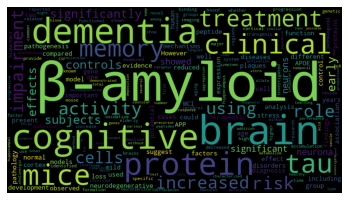

In [ ]:
plt.imshow(cloud_whole_period)
plt.axis('off')
plt.show()

The size of each word is relative to the importance that word had in the assessed studies. We can see that the biggest one is **β-amyloid** , that is a peptide that form the amyloid plaques, typical of this disease. These plaques acumulate in the **brain**, thus damaging its **cells**. This, in turn, leads to impariment in **cognitive** functions such as **memory**, which are main characteristics of **dementia**. Not by chance, these are the words that appear the most in the word cloud.

###3.2 The evolution of Alzheimer's Disease research

The word cloud we saw can give us a nice pespective of Alzheimer's Disease research overall, nevertheless, understanding how it progressed overtime  can offer new insights on the issue.

####Code:

In order to assess the change of word usage overtime a table with BOW and TF-IDF per year was built.

BOW

In [ ]:
df_bow_with_date = pd.concat([df_sample['pubdate_year'], df_bow], axis=1)
df_bow_with_date.dropna(subset=['pubdate_year'], inplace = True)
df_bow_with_date['pubdate_year'] = pd.to_datetime(df_bow_with_date['pubdate_year'], format='%Y')

In [ ]:
#DF with word count per year
bow_by_year = df_bow_with_date.groupby(pd.Grouper(key='pubdate_year', axis=0, freq='Y')).sum()

In [ ]:
#DF with the cumulative sum of word count per year
bow_cumsum = bow_by_year.cumsum()

TF-IDF

In [ ]:
df_tfidf_with_date = pd.concat([df_sample['pubdate_year'], df_tfidf], axis=1)
df_bow_with_date.dropna(subset=['pubdate_year'], inplace = True)
df_tfidf_with_date['pubdate_year'] = pd.to_datetime(df_tfidf_with_date['pubdate_year'], format='%Y')

In [ ]:
#DF with word count per year
tfidf_by_year = df_tfidf_with_date.groupby(pd.Grouper(key='pubdate_year', axis=0, freq='Y')).mean()

In [ ]:
#DF with the cumulative sum of word count per year
tfidf_cumsum = tfidf_by_year.cumsum()

In [ ]:
#DF with the 0.15% most used words to reduce computational use
top_015pct_list = [i for i in df_weights[df_weights['weight']>=df_weights['weight'].quantile(0.9985)]['word'] if i!=np.nan]
df_bcr = bow_cumsum['1980-1-1':].reindex(columns = top_015pct_list)

###3.2.1 Changes in the most used terms over the years 

A very dinamic way of understandig changes overtime is with a bar chart race. As shown below we can see the changes in the most used words overtime.

In [ ]:
import bar_chart_race as bcr
bcr.bar_chart_race(df=df_bcr, filename=None, n_bars=10, period_length=1000, period_fmt='%Y', filter_column_colors = True, title= 'Most common words in AD studies')

Interesting phenomenomena can be observed in this bar chart race. The main one is the appearence of relevant molecules that were discovered over the years, namely, the growth of studies with **β-amyloid** in the since 1987, or with **tau** since 1997 and **APOE** proteins in 1997 and 1999 respectively. The understanding of the relation of each of these main molecules with Alzheimer's led to a better understanding of its pathological mechanisms.

###3.2.2 Research with main molecules over the years

As we saw in the bar chart race, there are 3 main molecules that are associated with Alzheimer's disease: APOE, tau and β-amyloid. In the graph below we can see the number of times that each molecule was mentioned in the assessed studies. 

Bare in mind that it is an interactive graph, so you can remove molecules such as β-amyloid (by clicking in its label in the right side) to have a better understanding of the alterations in the other molecules. It is also possible to "zoom in" in the time scale by dragging the bars in the small graph below.

In [ ]:
fig3=px.line(bow_by_year[:'2020-12-1'].groupby((bow_by_year[:'2020-12-1'].index.year//2)*2+2).sum(), 
             y=['APOE', 'tau', 'β-amyloid'], 
             title = "Publications with main molecules", 
             labels={"pubdate_year": "Year",
                     '_variable': "Molecule",
                     '_value': 'Number of Publications'})

fig3.update_layout(
    title={
        'text': "Publications with main molecules",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig3.update_xaxes(rangeslider_visible=True)
fig3.show()

Observing the graph, we can clearly see that until the end of the 80s there were almost no publications with any of the molecules. Another fact that stands out is how β-amyloid publications are prevalent in Alzheimer's research.

Another interesting way of understanding more about a molecule using machine learning and Natural Language Processing is by assessing which words are associated with them.

####Code:

The Apriori algorithm of association rule learning was used to assess the terms that possessed high probabilistic relations with the main molecules.

In [ ]:
from apyori import apriori

ap = apriori(transactions = list(df_sample['abstract'].apply(text_process)), 
             min_support = 0.003, 
             min_confidence = 0.2, 
             min_lift = 3, 
             min_length = 2, 
             max_length = 2)
results = list(ap)

In [ ]:
#Results form apriori are returned as a list, this function turns that list into a df.
def inspect(results):
    word1         = [tuple(result[2][0][0])[0] for result in results]
    word2         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(word1, word2, supports, confidences, lifts))
df_ap_results = pd.DataFrame(inspect(results), columns = ['Word 1', 'Word 2', 'Support', 'Confidence', 'Lift'])

In [ ]:
#Taking only the words associated with the main molecules
df_molecules = df_ap_results[(df_ap_results['Word 1'].isin(['APOE', 'tau', 'β-amyloid'])) | (df_ap_results['Word 2'].isin(['APOE', 'tau', 'β-amyloid']))]

####3.2.2.1 Words associated with the main molecules

The graph below shows the words with probabilistic relations with the main molecules. Each circle in the graph represents a relation between two words. Two statistics are shown:

**Confidence**: The confidence expresses the probability of the word 2 appear given that word 1 is in the study. This is expressed in the graph by the size of the circle (Where higher the confidences are exxpressed in bigger circles). In the top left side, for example, it is shown the relation between the words "hyperphosphorylated" (Word 1) and "tau" (Word 2), with a confidence of 0.87. This means that when the word "hyperphosphorylated" there is a chance of 87% that the word "tau" will also be present.

**Support**: Shows the frequency in which a relation is observed across the studies. In the bottom right side, for example, there is a relation of the words "β-amyloid" and "precursor" with a support of 0.076. This means that this combination is found in 7.6% of the assessed studies.

It is possible to see the details of all relations in the graph by hovering the mouse over them.

In [ ]:
fig = px.scatter(df_molecules.sort_values('Support', ascending = False).head(20), 
                 x='Support', 
                 y='Word 1', 
                 size="Confidence", 
                 color = 'Word 2',
                 title = "Words associated with main molecules")

fig.update_layout(
    title={
        'text': "Words associated with main molecules",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Let's see if the associations between different terms and the main molecules reflect the biology od the disease:

Starting with **tau**, we can see that it is associated with the words hyperphosphorylated, phosphorilated, phosphorylation, neurofibrilary and tangles.au is an important protein for the proper function of neurons. The biochemical properties of this molecule are controlled by **phosphorylation**, meaning that this protein can be **phosphorylated** and **hyperphosphorylated**. These changes can alter its stucture to a point that it starts to form threads that accumulate as tangles inside of neurons, forming the **neurofibrilary tangles**.The presence of high levels of tau in the cerebrospinal fluid (**CSF**) is one of the main biomarkers of Alzheimer's disease.

The most researched molecule, **β-amyloid** was associated with "Aβ42", "amyloidogenic", "LOAD", "APP", "deposition" and "precursor". As it was the case with tau, these relations have a clear biological explanation. The β-amyloid peptide is formed form the amyloid **precursor** protein (**APP**) and these peptides can form oligomers, specially the **Aβ42**, that will form  deposits in the brain. This **amyloidogenetic** **deposition** is one of the most known characteristics of the most prevalent type of Alzheimer's disease, the late onset Alzheimer's disease (**LOAD**).

**APOE** began attractiong attention from researchers since it was discovered an **association** between the **allele** **ε4** and an increased **risk** of Alzeimer's disease. Meaning that people with this **genotype** had increased chances of manifesting the pathology.Interestingly, APOE was the only molecule that appeared as Word 1, meaning that in studies that mentioned APOE would frequently mention the associated words.

Overall we can clearly see that the words associated with the main Alzheimer's disease molecules are able to reflect true biological connections.

###3.3 Finding clusters of Alzheimer's disease studies


One way important way of understanding our data is to perform clusterization techniques. These machine learning technique allows us to find groups there are similar with each other and assessing each of the group seaparetly. Let's see if the publications we have can be divided in meaningful clusters.

#### 3.3.1 Cosine similarity, dimensionality reduction and clustering

**Cosine similarity** is a robust technique for measuring how similar two texts are from each other, making it an ideal parameter for clustering analysis. 

**Dimensionality reduction** is also important in these cases, since the clustering algorithms do not handle well datasets with too many variables like the one we are dealing with here. This technique will convert all variables present here to fewer variables preserving the original variablity.

The **Clustering** technique will take the features obtained after the dimensionality reduction to find the best number of clusters for our data.

##### Code and Statistics

In [ ]:
# Getting the cosine similarity from the TF-IDF.
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(tfidf, tfidf)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Here we will use PCA algorithm for dimensionality reduction. However, in order to optimize this process we first need to find out what is the optimal number of dimentions for our data.

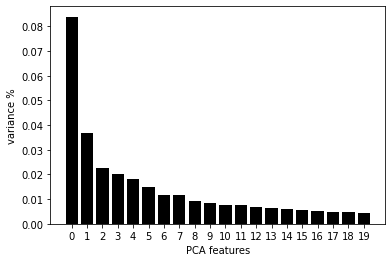

In [ ]:
# Standardizing the cosine similarity data.
X_std = StandardScaler().fit_transform(cos_sim)

# Using PCA algorithm with different number of features
pca = PCA(n_components=20, random_state=20)
principalComponents = pca.fit_transform(X_std)

# Plotting the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

As shown in the graph, we can see that the variance reduces significantly until the number 2, meaning that 3 PCA features is the ideal number (0, 1 and 2). Now let's see use K-means clustering technique to find the optimal number of clusters using the "elbow method".

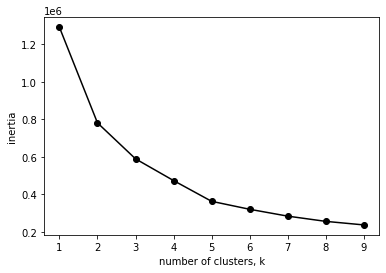

In [ ]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Creating a KMeans instance with k clusters
    model = KMeans(n_clusters=k, random_state=20)
    
    model.fit(PCA_components.iloc[:,:3])
    
    # Appending the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Inertia is a measure of how well-adjusted the clusters are. The "elbow" of the inertia by the number of clusters is formed with 5 clusters.

In [ ]:
#Building the model with 3 dimentions and 5 clusters.
pca_cos_sim = PCA(n_components=3, random_state = 20)
km_cos_sim = KMeans(n_clusters=5, random_state = 20)

components_cs = pca_cos_sim.fit_transform(X_std)
clusters_cs = km_cos_sim.fit_predict(components_cs)

#Storing the clusters in a TF-IDF dataframe.
df_tfidf_cluster = df_tfidf
df_tfidf_cluster['clusters_cs']=clusters_cs

#### 3.3.2 Exploring the clusters

Now let's explore the number of studies present in each of the 5 clusters obtained.

In [ ]:
fig = px.bar(df_tfidf_cluster.groupby('clusters_cs')['clusters_cs'].count(), 
             title= "Publications per Cluster",
             labels={"index": "Cluster",
                     "value": "Number of Studies",
                     "variable": "Cluster"
                     })

fig.update_layout(
    title={
        'text': "Publications per Cluster",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

The graph shows that all clusters have an important number of studies, now let's explore the words more commonly used in each of the clusters to see if it is possible to find a logic in this clusterization.

#####Cluster 0 or Clinical Prevention cluster

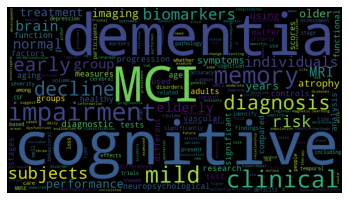

In [ ]:
cloud = wordcloud.WordCloud(width=900, height=500, random_state=4).generate_from_frequencies(df_tfidf_cluster.groupby('clusters_cs').mean().T[0])
plt.imshow(cloud)
plt.axis('off')
plt.show()

In this first cluster we can see several words that suggest a prevalence of clinical sutides, like "dementia", "cognitive", "clinical", "subjects" and "MCI". MCI stands for mild cognitive impairment, which are the initial symptoms of the disease, when people start to manifest cognitive declines, such as memory loss, without a significant impact on their daily lifes. The presence of terms such as "biomarkers" and "CSF" also suggest that these studies focus on early identification and prevention of the disease development. Therefore this cluster will be named "Clinical Prevention".

#####Cluster 1 or Tau and β-amyloid cluster

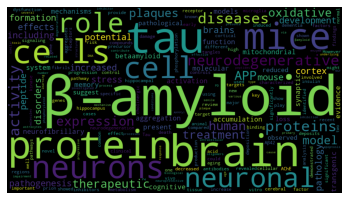

In [ ]:
cloud = wordcloud.WordCloud(width=900, height=500, random_state=4).generate_from_frequencies(df_tfidf_cluster.groupby('clusters_cs').mean().T[1])
plt.imshow(cloud)
plt.axis('off')
plt.show()

In this cluster we see a relavant presence of the "β-amyloid" term, however, other words also stand out, such as "tau", "protein", "brain", 
'cells" and "mice". Taken together, these main words suggest a prevalence of pre-clinical studies that evaluate both β-amyloid and tau molecules, so this cluster should be named the "Tau and β-amyloid".

##### Cluster 2 or Clinical Treatment cluster

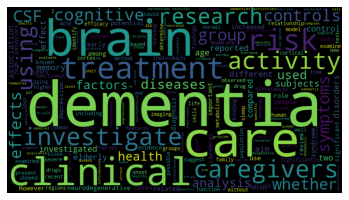

In [ ]:
cloud = wordcloud.WordCloud(width=900, height=500, random_state=4).generate_from_frequencies(df_tfidf_cluster.groupby('clusters_cs').mean().T[2])
plt.imshow(cloud)
plt.axis('off')
plt.show()

By looking at the word cloud from the studies of this cluster we can see words such as "Dementia", "Treatment" and "Caregivers", suggesting that these studies aim to find a treatment for the disease. Furthermore, the words "clinical" and "control" suggest the prevalence of clinical studies. Therefore, this cluster will be named "Clinical Treatment".

##### Cluster 3 or β-amyloid cluster

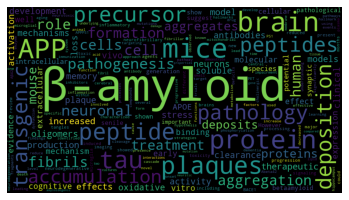

In [ ]:
cloud = wordcloud.WordCloud(width=900, height=500, random_state=4).generate_from_frequencies(df_tfidf_cluster.groupby('clusters_cs').mean().T[3])
plt.imshow(cloud)
plt.axis('off')
plt.show()

In this cluster we can see that the "β-amyloid" term stands out the most. Several of the other words that we see are the same that showed association with "β-amyloid", such as "oligomers", "deposits", "APP", "deposition" and "precursor". The presence of the words "transgenic" and "mice" suggest a prevalence of pre-clinical studies. From now on, we will address this cluster as the "β-amyloid".

##### Cluster 4 or APOE cluster

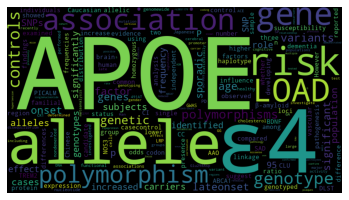

In [ ]:
cloud = wordcloud.WordCloud(width=900, height=500, random_state=4).generate_from_frequencies(df_tfidf_cluster.groupby('clusters_cs').mean().T[4])
plt.imshow(cloud)
plt.axis('off')
plt.show()

This might be the easiest cluster to name. The dominance of the term "APOE" is clearly identified, with the words that its associated to also presenting a relevant position, such as "allele", "ε4", "risk" and "genotype". Therefore, this cluster will be called the "APOE".



##### Code:

In [ ]:
df_tfidf_cluster_with_date = pd.concat([df_sample.reset_index(drop = True)['pubdate_year'], df_tfidf_cluster], axis=1)
df_tfidf_cluster_with_date.dropna(subset=['pubdate_year'], inplace = True)
df_tfidf_cluster_with_date['pubdate_year'] = pd.to_datetime(df_tfidf_cluster_with_date['pubdate_year'], format='%Y')
df_tfidf_cluster_with_date = df_tfidf_cluster_with_date[['pubdate_year', 'clusters_cs']]
cluster_per_year = pd.concat([df_tfidf_cluster_with_date, pd.get_dummies(df_tfidf_cluster_with_date['clusters_cs'])], axis=1)
cluster_per_year = cluster_per_year.sort_values('pubdate_year').groupby(pd.Grouper(key='pubdate_year', axis=0)).sum()
cluster_per_year = cluster_per_year.drop(['clusters_cs'], axis = 1)
cluster_per_year = cluster_per_year.rename(columns= {0: 'Clinical Prevention', 1:'Tau and β-amyloid' , 2: 'Clinical Treatment', 3:'β-amyloid' , 4: 'APOE'})

#### 3.3.3 Clusters of publications overtime

We will assess the changes in the number of publications in the main clusters overtime in two different ways. Firstly, by a bar chart race that will show the cumulative sum of publications in each cluster, this means that the numbers show in the year 2010, for example, refer to all publications in each cluster that happend up to the year 2010, including the previous years.

Whereas the second way will be by an interactive line plot that will show the number of publications in each cluster by year. Meaning that the number of studies in the year 2010 corresponds only to the publications made in that year, without any influence of the previous ones.

In [ ]:
bcr.bar_chart_race(df=cluster_per_year['1980-1-1':].cumsum(), filename=None,  period_length=1000, period_fmt='%Y', filter_column_colors = True, title= 'Main publication clusters')

In the bar chart race we can see that before 1990 the clinical studies of both treatment and prevention were more prevalent. However, once the studies with Tau and β-amyloid took the second place in the 1991 the order of the clusters with more publications remained unchanged.

In [ ]:
fig = px.line(cluster_per_year,  
              y=cluster_per_year.columns,
              title = 'Clusters of publications overtime',
              labels={"pubdate_year": "Year",
                     'variable': "Clusters",
                     'value': 'Number of Publications'}              
              )

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    title={
        'text': "Clusters of publications overtime",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

In the line plot we can have a better perspective of the changes in the number of publications between each year. Despite of the vast predominance of the Clinical Treatment cluster throughout the majority of the time, we can see the "boom" of the "Tau and β-amyloid" cluster from 1990 to 1999, alternating the first place durig several years.

More recently, from 2018 to 2020 we can see a rapid growth of the Clinical Prevention cluster, since the discovery of new biomarkers and preventive strategies appear as promising in the recent years.

Finnaly, the intepretation of the changes observed in the 2021 is very limited, since the COVID-19 pandemic has impacted almost all aspects of our lives world-wide and scientific research was not an exception.

##4. Conclusions

Here, using natural language processing we were able to have a bird's eye view of thousands of publications with Alzheimer's disease in PubMed database. We traveled through time and saw how the main breakthoughs in the field changed the profile of publications. We were also able to observe how assessing the words that are more closely associated with disease related molecules reflect the biology of the pathology. In addition, using clusterization techniques we were able to divide the publications into 5 relevant categories and to show the changes in the number of studies with each of these clusters overtime.

Overall, a new perspective on the research regarding Alzheimer's disease research is made possible with the use of data science and machine learning techniques. It is interesting to consider that these methodologies may lead researchers to find new treatments for this pathology that affects the life of millions of people.

Want to know more about Alzheimer's Disease? 
Check these out:

https://www.nia.nih.gov/health/alzheimers-disease-genetics-fact-sheet

https://pubmed.ncbi.nlm.nih.gov/20553310/
